In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os
import time
start_time = time.time()

def select_top(cases, sum_list = 1, top = 10 ):
    temp = {}
    if type( list(cases.keys())[0] ) == pd.Timestamp:
        for time, val in cases.items():
            temp[str(time.date())] = [val]
    cases = temp
    net_cases = {}
    result = []
    for st in cases:
        if sum_list:
            net_cases[st] = sum(cases[st].dropna())
        else:
            net_cases[st] = cases[st][-1]
    order = list(net_cases.values())
    order.sort(reverse = True)
    if top > 0:
        result = [key for key, value in net_cases.items() if value in order[:top] ]
    else:
        result = [key for key, value in net_cases.items() if value in order[top:] ]
    return result

#######################################################################################################################
#######################################################################################################################
############################################ Download Data ############################################################
#######################################################################################################################
#######################################################################################################################
print("Downloading data...\n")
raw_US = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv', 
                     index_col = 'date',
                     parse_dates = True).sort_index()
raw_states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv',
                     index_col = 'date',
                     parse_dates = True).sort_index()
raw_County = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv',
                     dtype = { 'fips' : str },
                     index_col = 'date',
                     parse_dates = True).sort_index()
raw_Global = pd.read_csv("https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv",
                        ).groupby('Country/Region').sum().transpose()[2:]
EU = pd.read_html('https://europa.eu/european-union/about-eu/countries_en')[0] 
EU_nation = list(EU['Countries']) + list(EU.dropna()['Countries.1'])
raw_Global['EU'] = 0
for countries in EU_nation:
    raw_Global['EU'] = raw_Global[countries] + raw_Global['EU']
    
raw_Global.index = pd.to_datetime(raw_Global.index)

cty_population = pd.read_csv('county population.csv', encoding='cp1252',
                             dtype = {'STATE' : str,
                                    'COUNTY': str },
                             usecols = [ 'STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'POPESTIMATE2019' ]
                            )

cty_population['fips'] = cty_population.apply(lambda row: ("0" + row.STATE)[-2:] + ("00" + row.COUNTY )[-3:], axis = 1 )
cty_population = cty_population[['STNAME', 'CTYNAME', 'fips', 'POPESTIMATE2019' ]]
cty_population.columns = ['state', 'county', 'fips', 'population']
cty_population = cty_population.loc[cty_population.state != cty_population.county]
cty_population = cty_population.set_index('fips')


population = pd.read_html('https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population')[0].set_index(['State'])["Population estimate, July 1, 2019[2]"]
pop_dict = dict(population)
pop_dict['Virgin Islands'] = pop_dict['U.S. Virgin Islands']

raw_states['cases per million'] = raw_states.apply(lambda row: 1000000*row.cases/pop_dict[row.state], axis = 1)
raw_states['deaths per million'] = raw_states.apply(lambda row: 1000000*row.deaths/pop_dict[row.state], axis = 1)
list_of_states = raw_states['state'].unique()

#######################################################################################################################
#######################################################################################################################
#######################################################################################################################
#######################################################################################################################
print("Parsing through data for US states...\n")

#######################################################################################################################
###################################Initialise variables################################################################
#######################################################################################################################
new_weekly_cases_state = {}
new_weekly_deaths_state = {}
percent_weekly_cases = {}
change_in_new_cases = {}
new_cases_per_mil = {}
new_death_per_mil = {}

wk_cases_county = {}
wk_deaths_county = {}
cases_cty_thou = {}
#######################################################################################################################
#####################################Loop Around#######################################################################
#######################################################################################################################

for state in list_of_states:
    total_case = round(100*raw_states.loc[raw_states['state'] == state].cases[-1]/raw_US.cases[-1], 4)
    if ( pop_dict[state] > 500000):
        wk_cases_county[state] = {}
        wk_deaths_county[state] = {}
        cases_cty_thou[state] = {}
        temp_county = raw_County.loc[raw_County.state == state]
        for cnty in temp_county.county.unique():
            if cnty == 'Unknown':
                continue
            wk_cases_county[state][cnty] = temp_county.loc[temp_county.county == cnty ].cases.diff(7)
            wk_deaths_county[state][cnty] = temp_county.loc[temp_county.county == cnty ].deaths.diff(7)
            
            ###Problems with these three county entries. 
            if cnty in [ 'New York City', 'Kansas City', 'District of Columbia' ]: continue
                
            fip = temp_county.loc[temp_county.county == cnty].fips.unique()[0]
            cty_popu = cty_population.loc[fip].population
            cases_cty_thou[state][cnty] = 1000*wk_cases_county[state][cnty]/cty_popu

        new_weekly_cases_state[state] = raw_states.loc[raw_states['state'] == state].cases.diff(7)
        new_weekly_deaths_state[state] = raw_states.loc[raw_states['state'] == state].deaths.diff(7)
        new_cases_per_mil[state] = raw_states.loc[raw_states['state'] == state]['cases per million'].diff(7)
        new_death_per_mil[state] = raw_states.loc[raw_states['state'] == state]['deaths per million'].diff(7)
        percent_weekly_cases[state] = 100*new_weekly_cases_state[state]/raw_US.cases.diff(7)
        change_in_new_cases[state] = 100*new_cases_per_mil[state].diff(14)[-1]/new_cases_per_mil[state][-15]
print('Data downloaded in ', time.time()-start_time)


Parsing through data for US states...

Data downloaded in  12.371242046356201


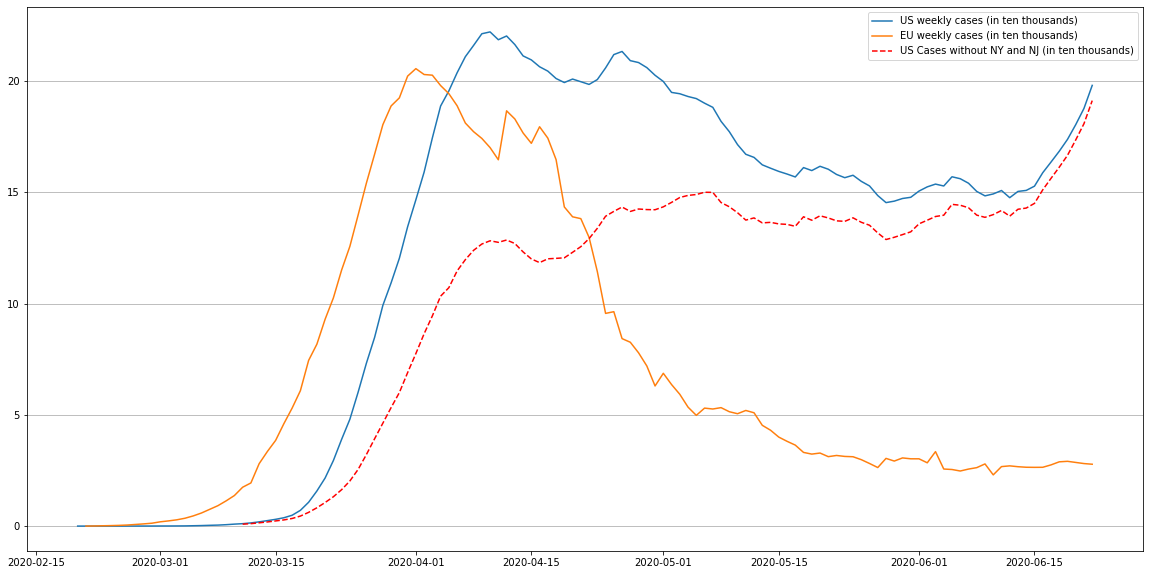

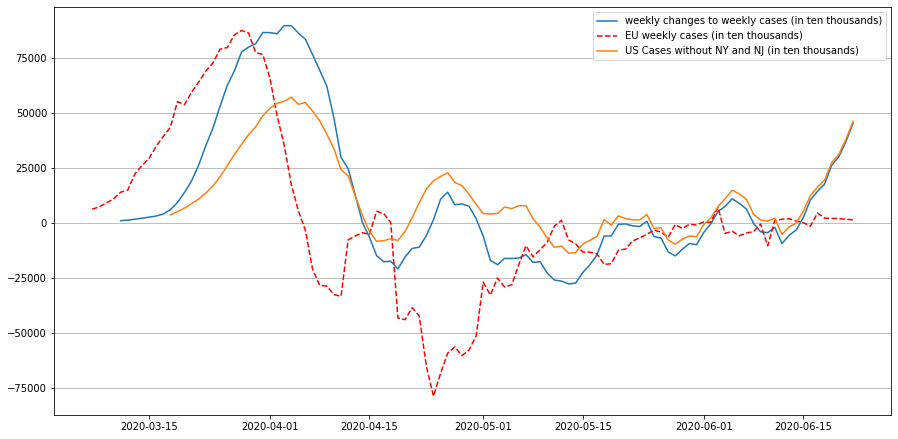

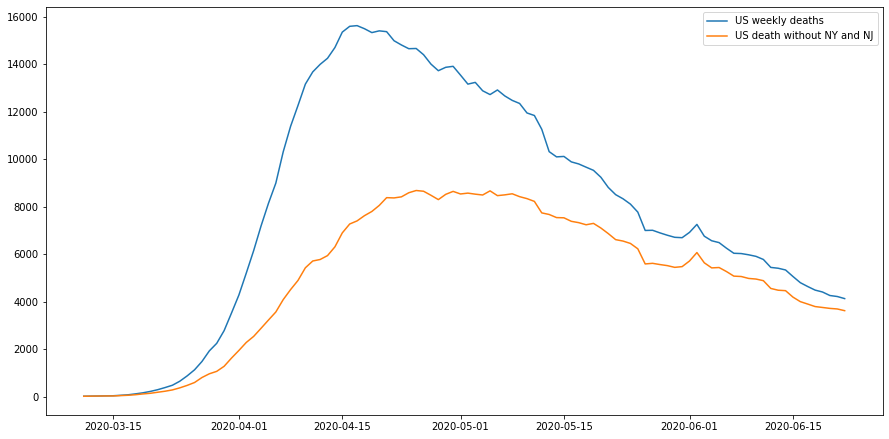

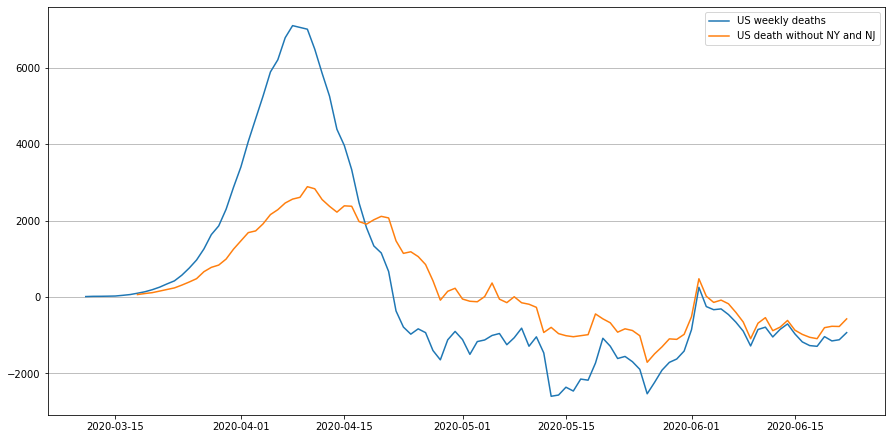

In [58]:
plt.figure(figsize = (20,10))
plt.plot(raw_US.cases.diff(7)[30:]/10000, label = "US weekly cases (in ten thousands)" )
plt.plot(raw_Global.EU.diff(7)[30:]/10000, label = "EU weekly cases (in ten thousands)")
plt.plot((raw_US.cases.diff(7) - (new_weekly_cases_state['New York'] + new_weekly_cases_state['New Jersey'] ))[30:]/10000, 'r--', label = "US Cases without NY and NJ (in ten thousands)" )
#plt.plot(raw_Global['US'].diff(7), label = "Global" )
plt.grid(axis = 'y')
plt.legend()

plt.figure(figsize = (15,7.5))
plt.plot(raw_US.cases.diff(7).diff(7)[50:], label = "weekly changes to weekly cases (in ten thousands)" )
plt.plot(raw_Global.EU.diff(7).diff(7)[45:],'r--', label = "EU weekly cases (in ten thousands)",  )
plt.plot((raw_US.cases.diff(7) - (new_weekly_cases_state['New York'] + new_weekly_cases_state['New Jersey'] )).diff(7)[30:], label = "US Cases without NY and NJ (in ten thousands)" )
plt.grid(axis = 'y')
plt.legend()

plt.figure(figsize = (15,7.5))
plt.plot(raw_US.deaths.diff(7)[50:], label = "US weekly deaths")
plt.plot((raw_US.deaths.diff(7) - (new_weekly_deaths_state['New York'] + new_weekly_deaths_state['New Jersey'] ))[50:], label = "US death without NY and NJ" )
plt.legend()

plt.figure(figsize = (15,7.5))
plt.plot(raw_US.deaths.diff(7).diff(7)[50:], label = "US weekly deaths")
plt.plot((raw_US.deaths.diff(7) - (new_weekly_deaths_state['New York'] + new_weekly_deaths_state['New Jersey'] )).diff(7)[50:], label = "US death without NY and NJ" )
plt.grid(axis = 'y')
plt.legend()

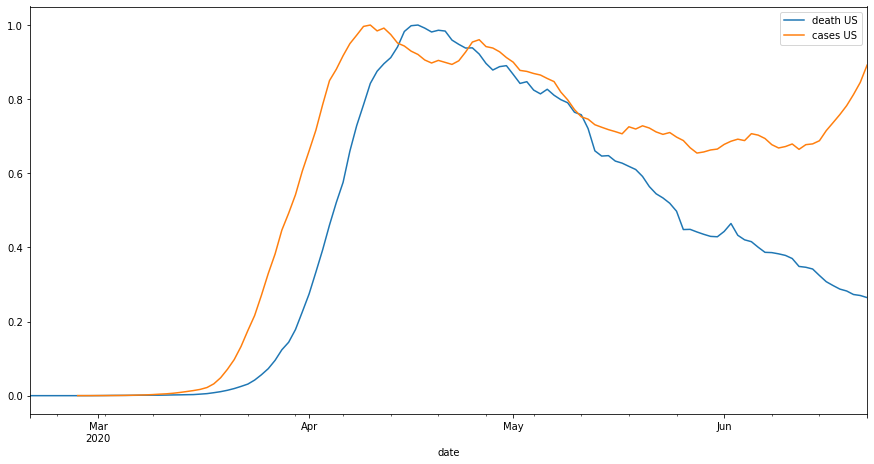

death  2020-04-17 	 15625.0
cases  2020-04-10 	 222100.0


In [67]:
US_death_normalised = raw_US.deaths.diff(7) / max(raw_US.deaths.diff(7).dropna())
US_cases_normalised = raw_US.cases.diff(7).dropna() / max(raw_US.cases.diff(7).dropna())

plt.figure(figsize = (15,7.5))
US_death_normalised[30:].plot(label = "death US")
US_cases_normalised[30:].plot(label = "cases US")
plt.legend()
plt.show()
##############EVALUATE DATE OF MAXIMUMS FOR CASES AND DEATH IN US
print( 'death ', select_top(US_death_normalised.dropna().to_dict(), sum_list = 0, top = 1 )[0], '\t', max(raw_US.deaths.diff(7).dropna()))
print( 'cases ', select_top(US_cases_normalised.dropna().to_dict(), sum_list = 0, top = 1 )[0], '\t', max(raw_US.cases.diff(7).dropna()))



['California', 'Arizona', 'Texas', 'Utah', 'Oregon', 'Florida', 'Georgia', 'Nevada', 'Hawaii', 'Oklahoma', 'South Carolina', 'Kansas', 'Ohio', 'Arkansas', 'Delaware', 'Wyoming', 'Alabama', 'Idaho', 'Montana', 'West Virginia']
['Illinois', 'Massachusetts', 'Rhode Island', 'New Hampshire', 'Maryland', 'District of Columbia', 'Vermont', 'Connecticut', 'Michigan', 'Puerto Rico']


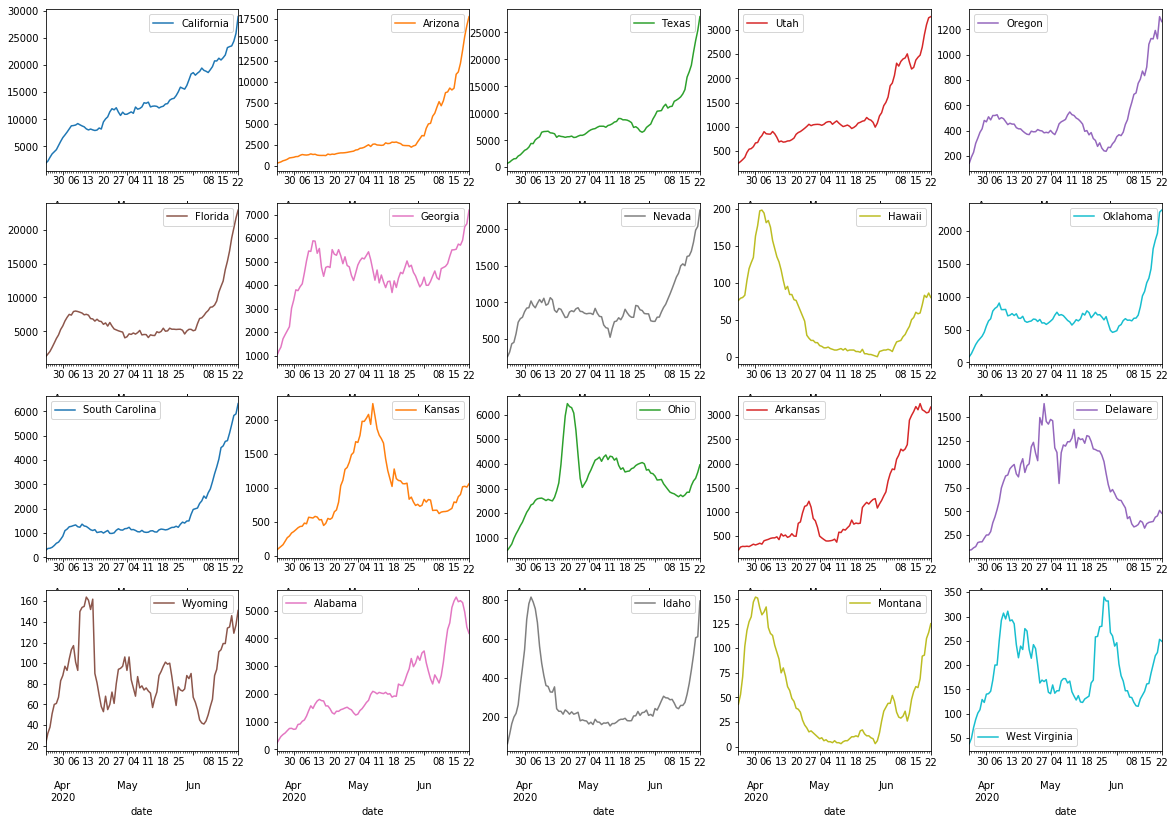

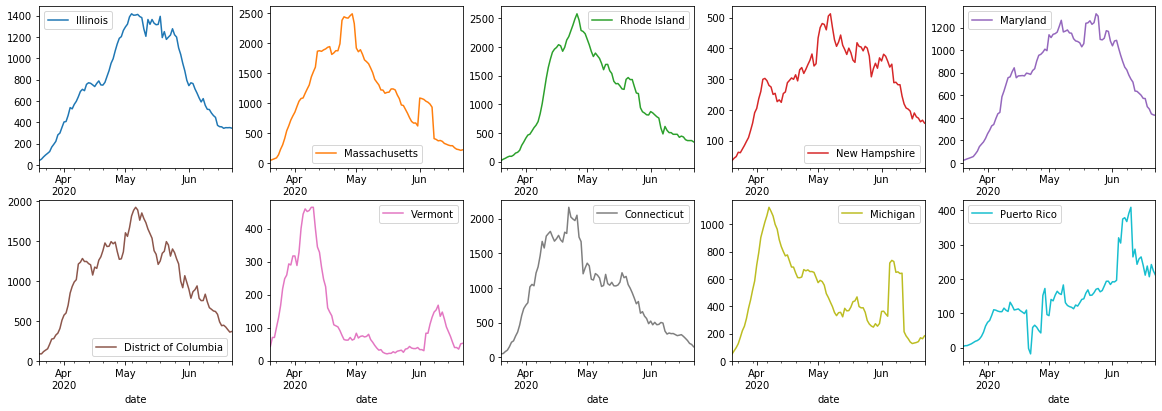

In [61]:
order = list(change_in_new_cases.values())
order.sort(reverse = True)
top_10_states = [key for key, value in change_in_new_cases.items() if value in order[:20] ]
bottom_states = [key for key, value in change_in_new_cases.items() if value in order[-10:]]
print(top_10_states)
print(bottom_states)

top_10 = pd.DataFrame()
bottom = pd.DataFrame()
for st in top_10_states:
#    top_10[st] = new_cases_per_mil[st][-90:]
    top_10[st] = new_weekly_cases_state[st]
for st in bottom_states:
    bottom[st] = new_cases_per_mil[st]
    
top_10.dropna(inplace = True)
top_10.plot(subplots = True, layout = (10,5), figsize = (20,35), sharex=False)

bottom.dropna(inplace = True)
bottom.plot(subplots = True, layout = (10,5), figsize = (20,35), sharex=False)
plt.show()
#top_10['Oregon'].plot(figsize = (10,7.5))

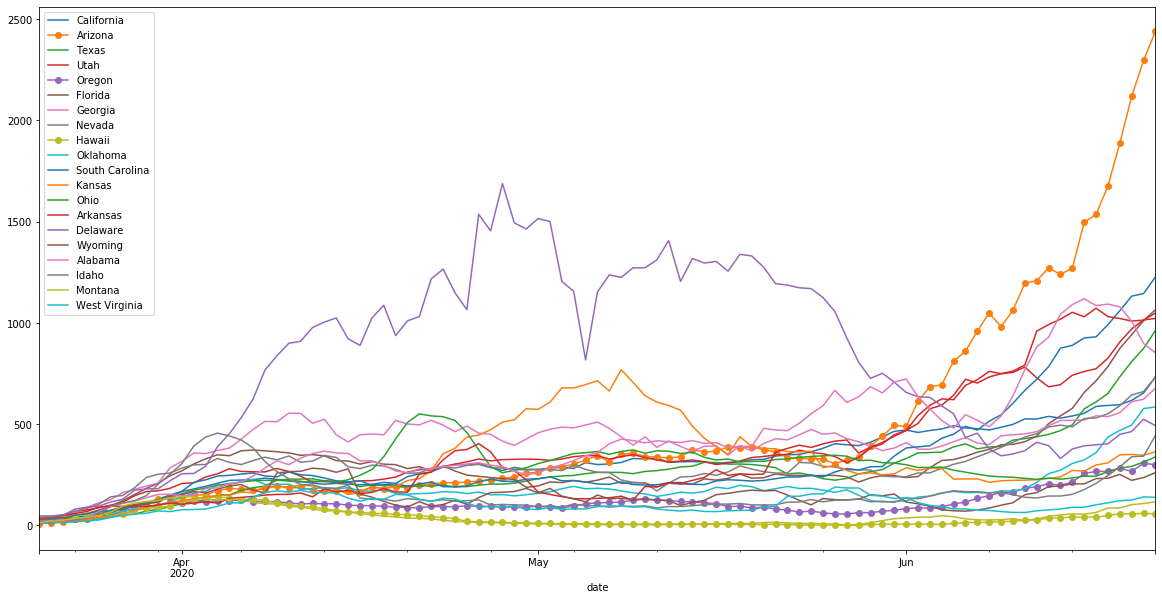

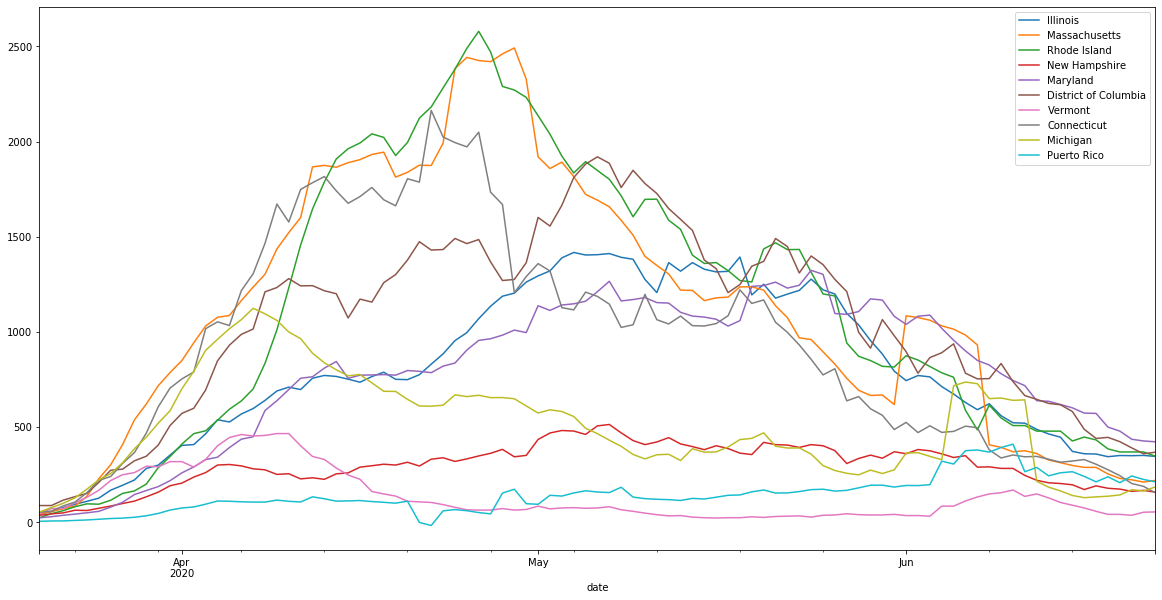

In [62]:
plt.figure(figsize = (20,10))
for st in top_10_states:
    if st == 'Hawaii' or st == 'Arizona' or st == 'Oregon' :
        new_cases_per_mil[st]['2020-03-20':].plot(label = st, marker='o')
    else :
        new_cases_per_mil[st]['2020-03-20':].plot(label = st )
plt.legend()

plt.figure(figsize = (20,10))
for st in bottom_states:
    if st == 'New Jersey' or st == 'New York' :
        new_cases_per_mil[st]['2020-03-20':].plot(label = st, marker='o')
    else :
        new_cases_per_mil[st]['2020-03-20':].plot(label = st )
plt.legend()


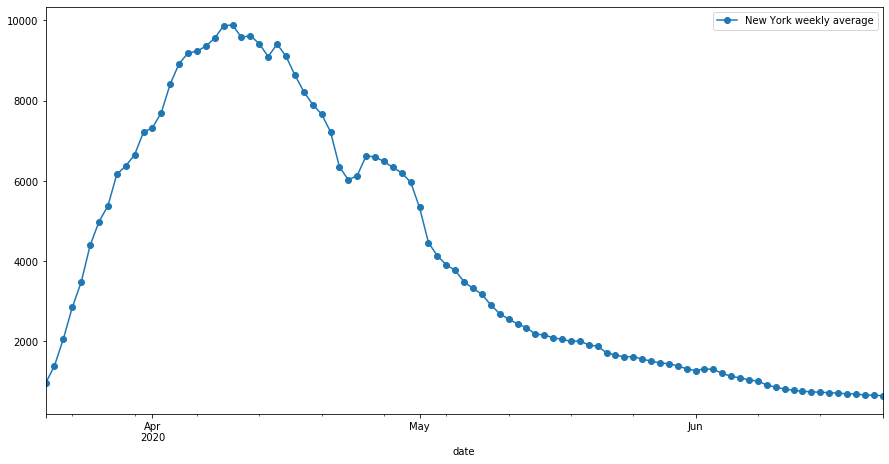

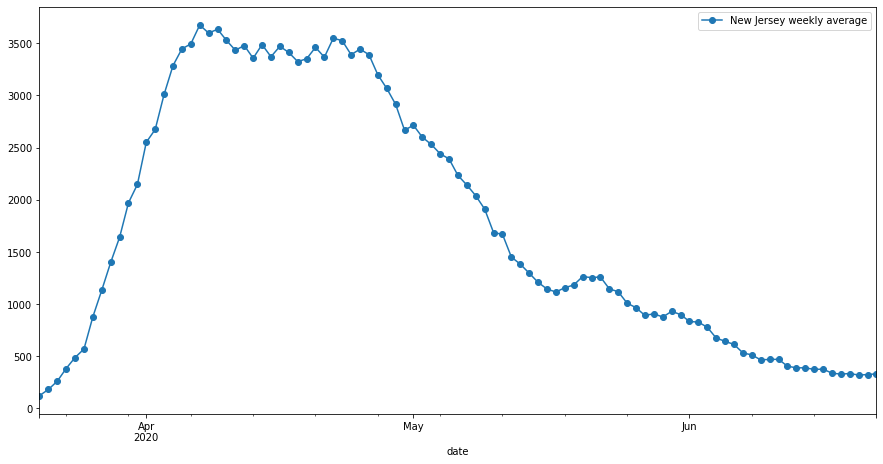

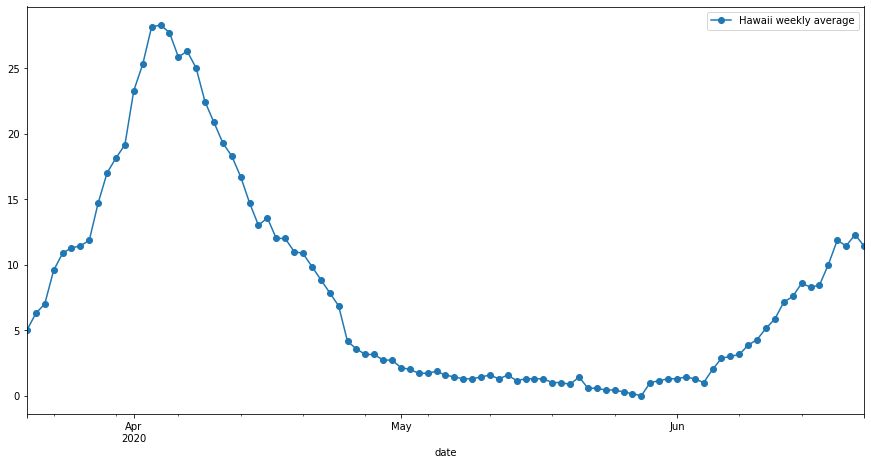

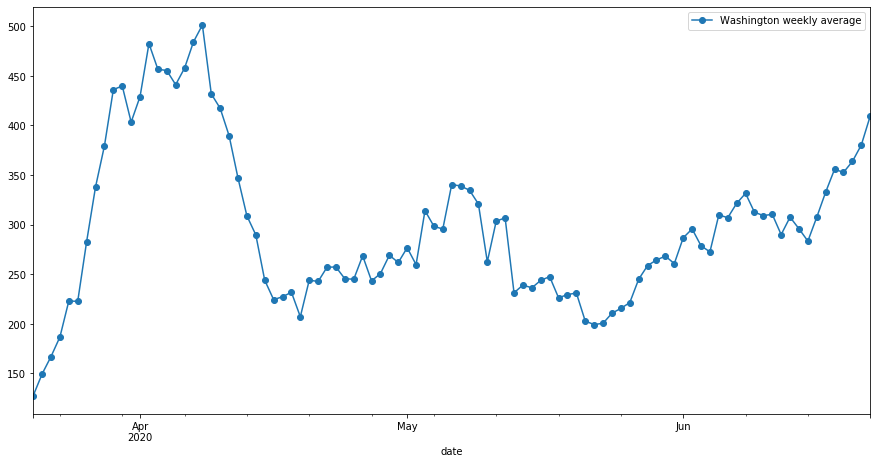

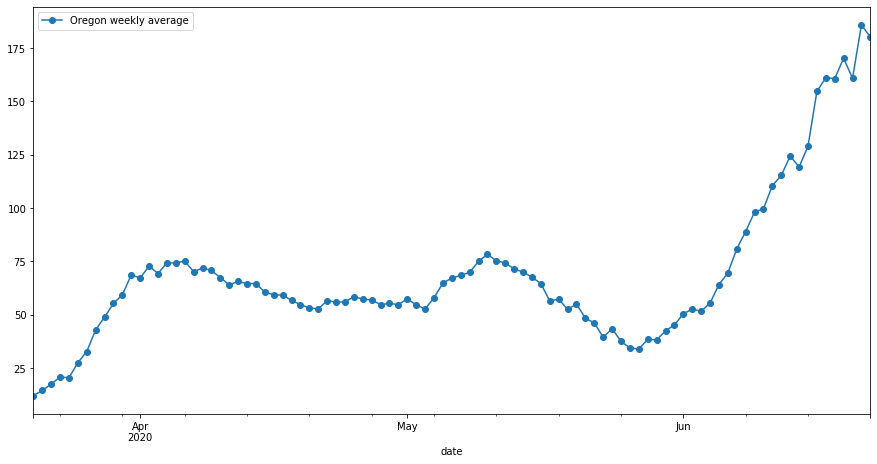

In [5]:
interested_state = ['New York', 'New Jersey', 'Hawaii', 'Washington', 'Oregon']

for st in interested_state:
    plt.figure(figsize = (15,7.5))
    (new_weekly_cases_state[st]['2020-03-20':]/7).plot(label = st + ' weekly average', marker='o')
    plt.legend()



In [6]:
def start_of_pandemic(cases, ratio = -1, limit = -1):
    if limit == -1:
        return [ date for date, val in dict(cases).items() if val >= cases.max()/ratio ][0].date() + dt.timedelta(days = -1)
    else:
        return [ date for date, val in dict(cases).items() if val >= limit ][0].date() + dt.timedelta(days = -1)

for st, cases in new_cases_per_mil.items():
    cases.dropna(inplace = True)


<Figure size 1080x720 with 0 Axes>

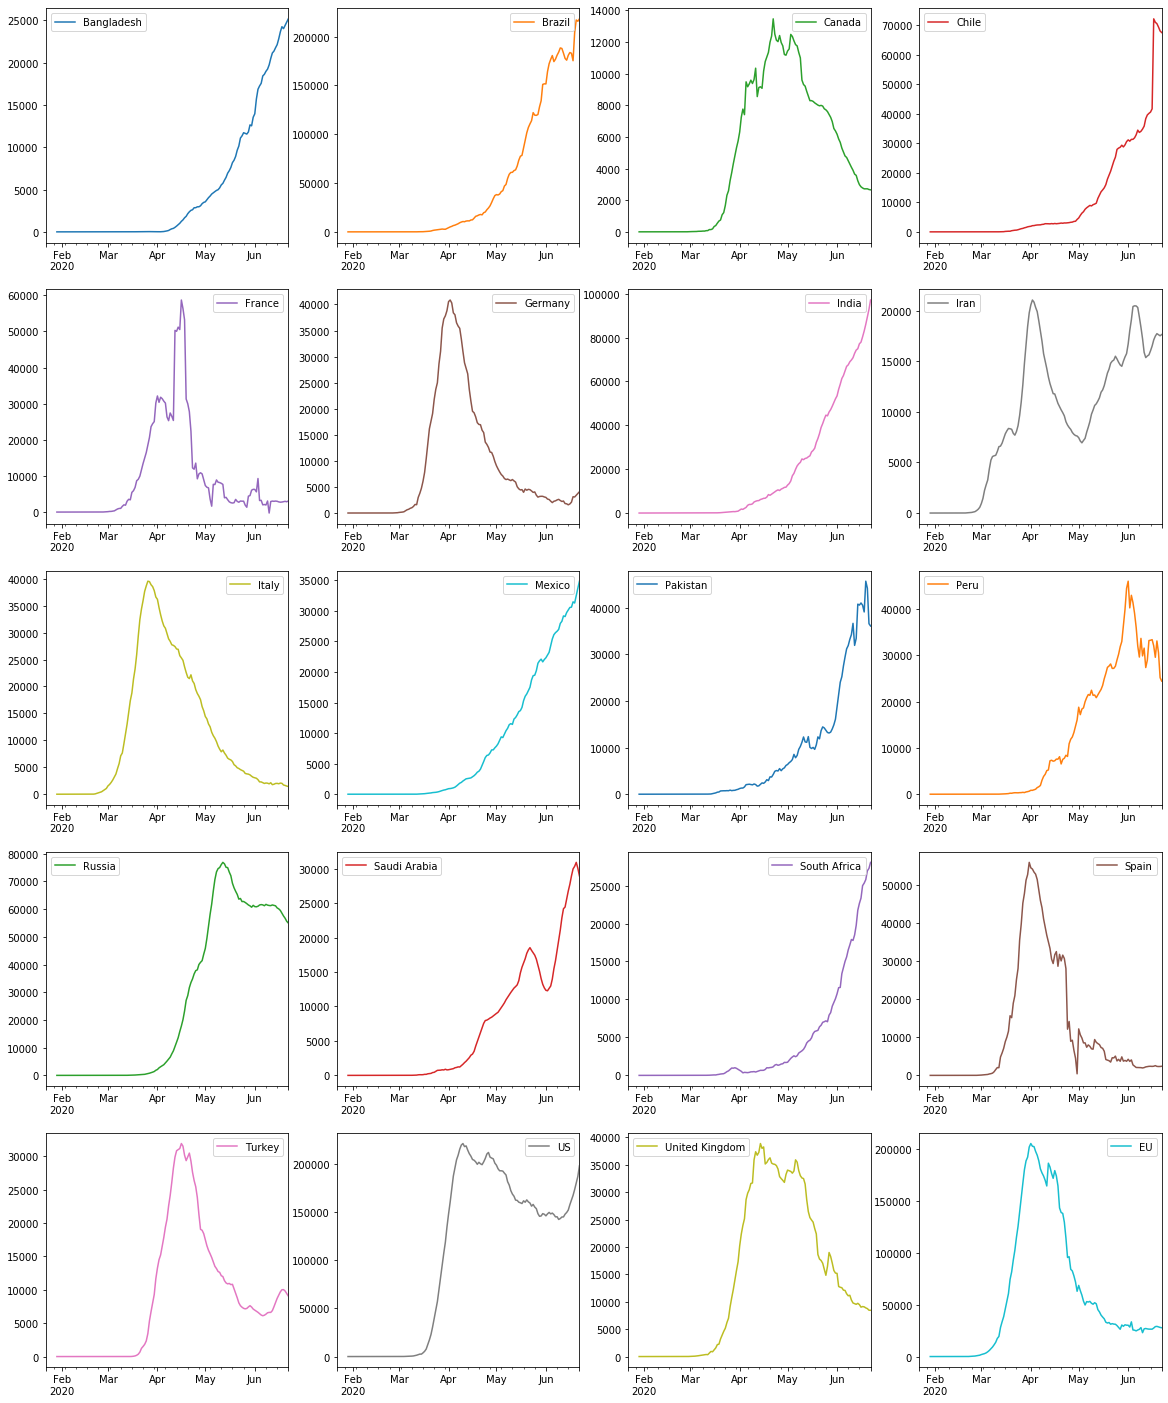

In [7]:
count_cases = raw_Global.iloc[-1].to_dict()
global_cases = list(count_cases.values())
global_cases.sort(reverse = True)
countries = [key for key, value in count_cases.items() if value in global_cases[:20]]

sliced_countries = raw_Global[countries]
plt.figure(figsize = (15,10))
sliced_countries.diff(7).plot(subplots = True, layout = (5,4), figsize = (20,25), sharex=False)
plt.show()

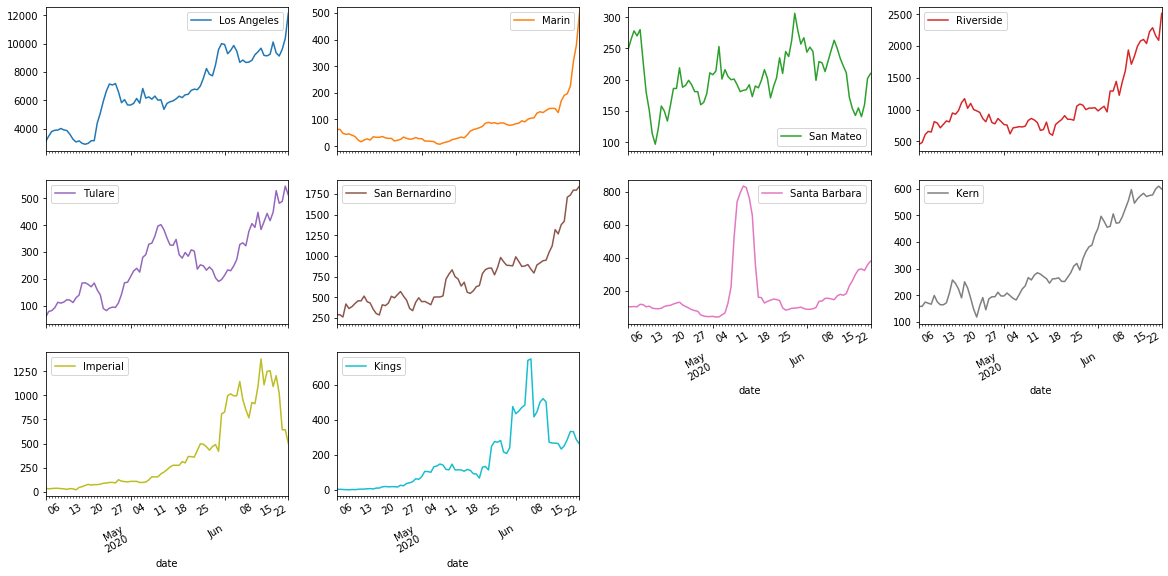

In [8]:
   
cal = pd.DataFrame(wk_cases_county['California'])
#select_top( wk_cases_county['California'], sum_list = 1, top = 10 )
worst_cases = select_top( cases_cty_thou['California'], sum_list = 1, top = 10 )

top_10 = pd.DataFrame()
for cnty in worst_cases:
    top_10[cnty] = wk_cases_county['California'][cnty].dropna()
top_10.dropna(inplace = True)    
top_10.plot( subplots = True, layout = (3, 4), figsize = (20,10), sharex = True )
plt.show()